In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
target_names = iris.target_names
target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [3]:
feature_names = iris.feature_names
feature_names = [name.replace(' (cm)', '') for name in feature_names]
feature_names = [name.replace(' ', '_') for name in feature_names]
feature_names



['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [4]:
from fuzzycocopython import FuzzyCocoClassifier

model = FuzzyCocoClassifier(nbRules=5, maxGenPop1=20, random_state=412, nbInSets=2)
model.fit(X_train, y_train, feature_names=feature_names, target_name="species")

FuzzyCocoClassifier(maxGenPop1=20, nbRules=5, random_state=412)

In [5]:
model.predict(X_test)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 2, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0])

In [6]:
model.score(X_test, y_test)

0.9666666666666667

In [7]:
model.fitness_history_

[0.9940246816779297,
 0.9940282621272726,
 0.9971785416987602,
 0.9971785416987602,
 0.9971820299457036,
 0.9971820299457036,
 0.9971885853568688,
 0.9971885853568688,
 0.9971885853568688,
 0.9971885853568688,
 0.9972438967450271,
 0.9971885853568688,
 0.9971885853568688,
 0.9971885853568688,
 0.9971885853568688,
 0.9971885853568688,
 0.9971885853568688,
 0.9971902058139879,
 0.9971885853568688,
 0.9971885853568688]

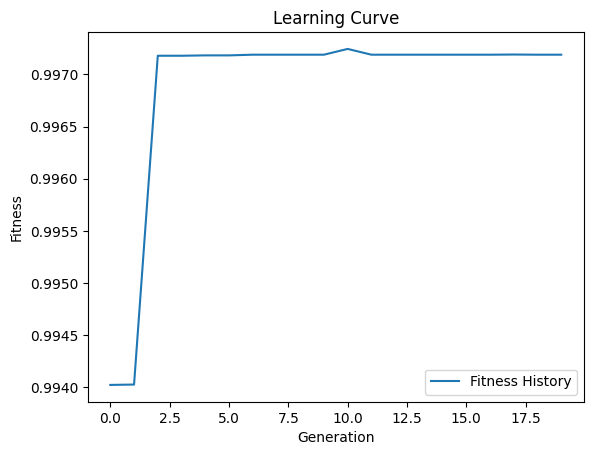

In [15]:
plt.plot(model.fitness_history_, label='Fitness History')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [8]:
model.rules_

[IF (petal_width is High AND_min petal_length is High), THEN (species is High),
 IF (sepal_length is High), THEN (species is High)]

In [17]:
model.default_rules_

[ELSE (species is Low)]

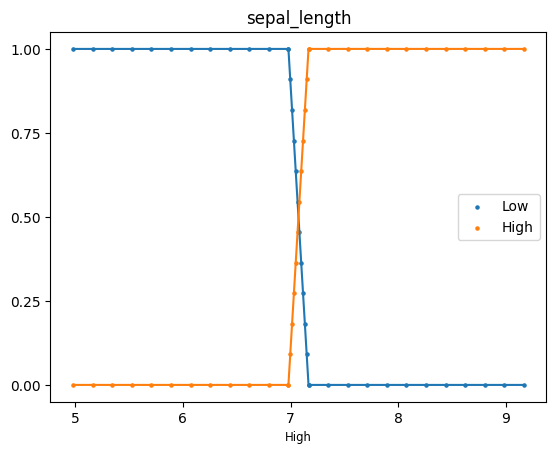

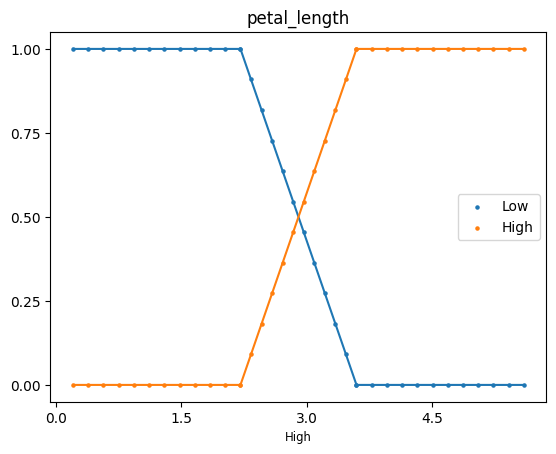

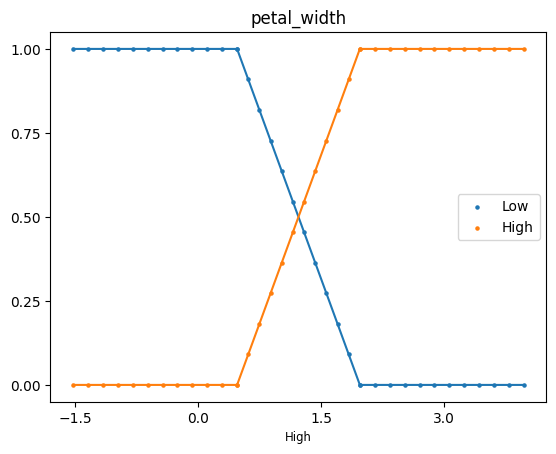

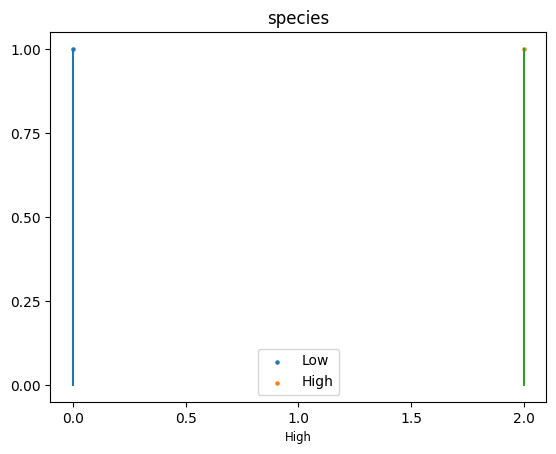

In [9]:
model.plot_fuzzy_sets()

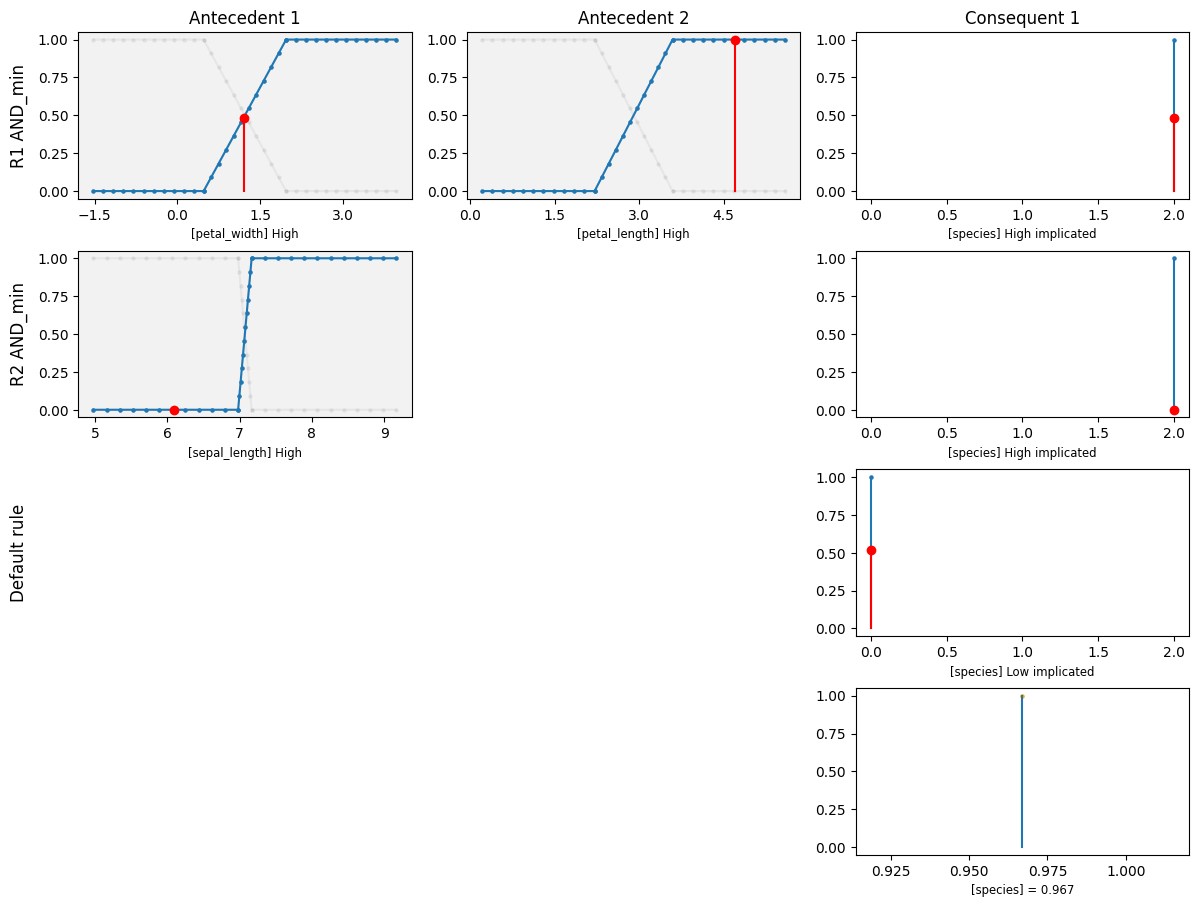

In [10]:
input_sample = X_test[0]
model.plot_aggregated_output(input_sample)

In [11]:
from joblib import dump

dump(model, 'modeltest.pkl')

['modeltest.pkl']

In [12]:
from joblib import load

modeltest = load('modeltest.pkl')

In [13]:
modeltest

FuzzyCocoClassifier(maxGenPop1=20, nbRules=5, random_state=412)

In [14]:
modeltest.score(X_test, y_test)

0.9666666666666667